# **Structural comparison of *de novo* proteins, random sequences, and established proteins**

In [1]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp

In [2]:
#Define color palette for plots
palette = sns.color_palette(palette=["#A44328","#43978D", "#EAC435"])

---
## Create datasets for the comparisons

In [3]:
# Load prediction data
dn = pd.read_csv("Data/de_novo_proteins_data.csv", index_col=0)
dn=dn[(dn["mechanism"] == "denovo") | (dn["mechanism"] == "denovo-intron")]

est = pd.read_csv("Data/established_proteins_data.csv", index_col=0)
est = est[est["isDeNovo"] == False]

rd = pd.read_csv("Data/random_sequences_data.csv", index_col=0)

#pLDDT
pLDDT = pd.DataFrame()
pLDDT["Random"] = rd["max_pLDDT"]
pLDDT["De Novo"] = dn["max_pLDDT"]
pLDDT["Established Proteins"] = est["pLDDT"]


#Alpha-Helices AlphaFold Models
af_alpha = pd.DataFrame()
af_alpha["Random"] = rd["alpha_content_AF"]
af_alpha["De Novo"] = dn["alpha_content_AF"]
af_alpha["Established Proteins"] = est["alpha_content_AF"]


#Beta-Sheets AlphaFold Models
af_beta = pd.DataFrame()
af_beta["Random"] = rd["beta_content_AF"]
af_beta["De Novo"] = dn["beta_content_AF"]
af_beta["Established Proteins"] = est["beta_content_AF"]

#Combined secondary structure AlphaFold Models
af_secondary = pd.DataFrame()
af_secondary["Random"] = rd["alpha_content_AF"] + rd["beta_content_AF"]
af_secondary["De Novo"] = dn["alpha_content_AF"] + dn["beta_content_AF"]
af_secondary["Established Proteins"] = est["alpha_content_AF"] + est["beta_content_AF"]


#Diorder predictions - flDPnn
disorder = pd.DataFrame()
disorder["Random"] = rd["fraction_disorder_fldpnn"]
disorder["De Novo"] = dn["fraction_disorder_fldpnn"]
disorder["Established Proteins"] = est["fraction_disorder_fldpnn"]


---
### Define helping functions for plotting

In [4]:
#define function to plot median valuse
def add_medians(ax, df):
    ax.scatter(
        x=[0,1,2], 
        y=[np.nanmedian(df["Random"]), np.nanmedian(df["De Novo"]), np.nanmedian(df["Established Proteins"])], 
        marker="d",
        color="k"
    )

#define function to add statistical annotations to plots
def add_stats(ax, df, y=1.05, offset=0.075):
    """
    Adds statistical annotations to a plot.

    Args:
        ax: Axes object to which the annotations will be added.
        df: DataFrame containing the data for statistical analysis.
        y: y-coordinate for the annotations.
        offset: Offset for adjusting the y-coordinate of certain annotations.
    """

    def stars(p):
        """
        Assigns star symbols based on the p-value.

        Args:
            p: p-value for which stars need to be assigned.

        Returns:
            Star symbols corresponding to the p-value.
        """
        if p < 0.0001:
            return "****"
        elif p < 0.001:
            return "***"
        elif p < 0.01:
            return "**"
        elif p < 0.05:
            return "*"
        else:
            return "n.s."

    # Perform Kruskal-Wallis test
    KruskalResult = kruskal(df["Random"], df["De Novo"], df["Established Proteins"], nan_policy="omit")

    # Print Kruskal-Wallis test result
    print(KruskalResult, "\n")

    # Check if Kruskal-Wallis test p-value is significant
    if KruskalResult.pvalue < 0.05:
        # Extract non-null data for Dunn's test
        data = [df["Random"].dropna(), df["De Novo"].dropna(), df["Established Proteins"].dropna()]

        # Perform Dunn's test with Holm adjustment
        dunn = sp.posthoc_dunn(data, p_adjust="Holm")

        # Print Dunn's test result
        print("Dunn-Test: \n", dunn, "\n")

        # Extract p-values for pairwise comparisons
        pval_rd_dn = dunn[1].iloc[1]
        pval_rd_est = dunn[1].iloc[2]
        pval_dn_est = dunn[2].iloc[2]

        # Print the pairwise comparison p-values
        print("P-Value random vs. de novo:", pval_rd_dn)
        print("P-Value random vs. conserved:", pval_rd_est)
        print("P-Value de novo vs. conserved:", pval_dn_est)

        # Add annotation for "random" vs. "de novo" comparison if significant
        if stars(pval_rd_dn) != "n.s.":
            ax.plot([0.05, 0.95], [y, y], lw=0.5, c="k")
            ax.text(0.5, y, stars(pval_rd_dn), ha="center", va="bottom")

        # Add annotation for "random" vs. "conserved" comparison if significant
        if stars(pval_rd_est) != "n.s.":
            ax.plot([0, 2], [y+offset, y+offset], lw=0.5, c="k")
            ax.text(1, y+offset, stars(pval_rd_est), ha="center", va="bottom")

        # Add annotation for "de novo" vs. "conserved" comparison if significant
        if stars(pval_dn_est) != "n.s.":
            ax.plot([1.05, 1.95], [y, y], lw=0.5, c="k")
            ax.text(1.5, y, stars(pval_dn_est), ha="center", va="bottom")


---
## Compare structural data

KruskalResult(statistic=1934.0096922259318, pvalue=0.0) 

Dunn-Test: 
               1              2              3
1  1.000000e+00   7.182617e-27   0.000000e+00
2  7.182617e-27   1.000000e+00  5.052476e-155
3  0.000000e+00  5.052476e-155   1.000000e+00 

P-Value random vs. de novo: 7.182616956886796e-27
P-Value random vs. conserved: 0.0
P-Value de novo vs. conserved: 5.052475662983297e-155


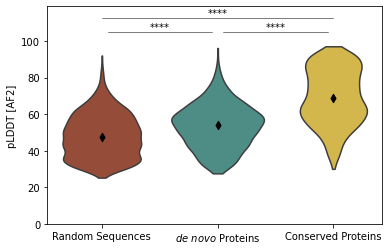

In [5]:
#Plot pLDDT & compare distributions
pLDDT_plot = sns.violinplot(data=pLDDT, palette=palette, cut=0, inner=None)
pLDDT_plot.set_ylabel("pLDDT [AF2]")
pLDDT_plot.set_ylim(0,119)
pLDDT_plot.set_xticklabels(["Random Sequences", r"$\it{de}$ $\it{novo}$ Proteins", "Conserved Proteins"])

add_medians(pLDDT_plot, pLDDT)
add_stats(pLDDT_plot, pLDDT, y=105, offset=7.5)

KruskalResult(statistic=272.317732632474, pvalue=7.361319992047931e-60) 

Dunn-Test: 
               1             2             3
1  1.000000e+00  1.463510e-09  1.468305e-60
2  1.463510e-09  1.000000e+00  5.158853e-16
3  1.468305e-60  5.158853e-16  1.000000e+00 

P-Value random vs. de novo: 1.4635099254876102e-09
P-Value random vs. conserved: 1.4683048819731396e-60
P-Value de novo vs. conserved: 5.158852768636081e-16


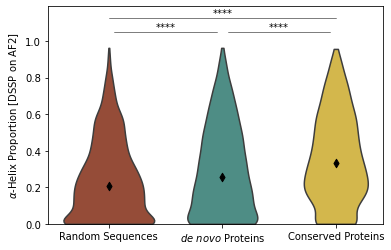

In [6]:
#Plot & compare alpha-helix content of AlphaFold models
af_alpha_plot = sns.violinplot(data=af_alpha, palette=palette, cut=0, inner=None)
af_alpha_plot.set_ylabel(r"$\alpha$-Helix Proportion [DSSP on AF2]")
af_alpha_plot.set_ylim(0,1.19)
af_alpha_plot.set_xticklabels(["Random Sequences", r"$\it{de}$ $\it{novo}$ Proteins", "Conserved Proteins"])

add_medians(af_alpha_plot, af_alpha)
add_stats(af_alpha_plot, af_alpha)

KruskalResult(statistic=84.07636724957587, pvalue=5.534123192274215e-19) 

Dunn-Test: 
               1             2             3
1  1.000000e+00  5.319107e-19  4.394545e-07
2  5.319107e-19  1.000000e+00  1.129760e-05
3  4.394545e-07  1.129760e-05  1.000000e+00 

P-Value random vs. de novo: 5.319107219000011e-19
P-Value random vs. conserved: 4.3945450358632596e-07
P-Value de novo vs. conserved: 1.1297601223225275e-05


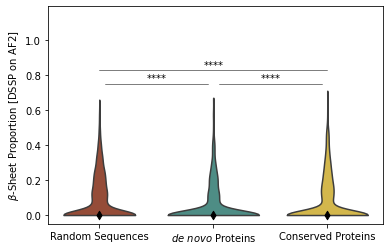

In [7]:
#Plot & compare beta-sheet content of AlphaFold models
af_beta_plot = sns.violinplot(data=af_beta, palette=palette, cut=0, inner=None)
af_beta_plot.set_ylabel(r"$\beta$-Sheet Proportion [DSSP on AF2]")
af_beta_plot.set_ylim(-0.05, 1.19)
af_beta_plot.set_xticklabels(["Random Sequences", r"$\it{de}$ $\it{novo}$ Proteins", "Conserved Proteins"])

add_medians(af_beta_plot, af_beta)
add_stats(af_beta_plot, af_beta, y=0.75)


KruskalResult(statistic=298.54103832395066, pvalue=1.4881174766224916e-65) 

Dunn-Test: 
               1             2             3
1  1.000000e+00  9.377256e-03  1.092821e-61
2  9.377256e-03  1.000000e+00  2.590429e-31
3  1.092821e-61  2.590429e-31  1.000000e+00 

P-Value random vs. de novo: 0.00937725634421612
P-Value random vs. conserved: 1.0928211668507488e-61
P-Value de novo vs. conserved: 2.590429280477904e-31


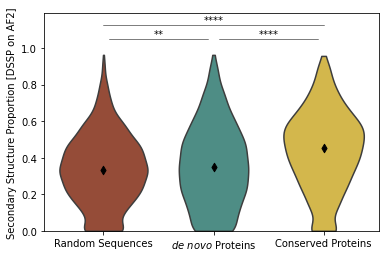

In [8]:
#Plot & compare secondary structure content of AlphaFold models
secondary_plot = sns.violinplot(data=af_secondary, palette=palette, inner=None, cut=0)
secondary_plot.set_ylabel("Secondary Structure Proportion [DSSP on AF2]")
secondary_plot.set_ylim(0, 1.19)
secondary_plot.set_xticklabels(["Random Sequences", r"$\it{de}$ $\it{novo}$ Proteins", "Conserved Proteins"])

add_medians(secondary_plot, af_secondary)
add_stats(secondary_plot, af_secondary)

KruskalResult(statistic=193.52266956395349, pvalue=9.486068198057177e-43) 

Dunn-Test: 
               1             2             3
1  1.000000e+00  2.257930e-12  1.593068e-15
2  2.257930e-12  1.000000e+00  1.355672e-42
3  1.593068e-15  1.355672e-42  1.000000e+00 

P-Value random vs. de novo: 2.257930447630673e-12
P-Value random vs. conserved: 1.5930679381059843e-15
P-Value de novo vs. conserved: 1.3556716375930577e-42


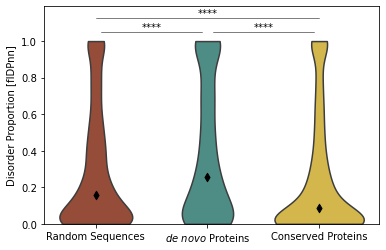

In [9]:
#Plot & compare disorder content predicted by flDPnn
disorder_plot = sns.violinplot(data=disorder, palette=palette, inner=None, cut=0)
disorder_plot.set_ylabel("Disorder Proportion [flDPnn]")
disorder_plot.set_ylim(0, 1.19)
disorder_plot.set_xticklabels(["Random Sequences", r"$\it{de}$ $\it{novo}$ Proteins", "Conserved Proteins"])

add_medians(disorder_plot, disorder)
add_stats(disorder_plot, disorder)